In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime, date
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *

2024-10-03 14:04:25.323167: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 14:04:25.328001: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 14:04:25.344063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 14:04:25.369495: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 14:04:25.376813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 14:04:26.760146: W tensorflow/compiler/tf2tensorrt/utils/p

In [2]:
data = pd.read_csv('/home/hoangbaoan1901/Development/predictive-analysis/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv')

In [3]:
data = data.drop(columns=['Date'])


In [4]:
data.head()

,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,Active Addr Cnt,Xfer Cnt,Mean Tx Size (native units),Total Fees (USD),Mean Hash Rate,...,RUB,Tweets,Google,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,278.740997,280.391998,276.365997,279.584991,42484800.0,283150,497302,2.057514,7235.134845,356031.3023,...,64.480003,47467,90.000000,0,0,0,0,1,0,0
1,279.742004,279.928009,260.709991,260.997009,58533000.0,266587,284532,3.675623,5806.842316,420413.4050,...,64.480003,29031,91.578947,0,0,0,0,0,1,0
2,261.115997,267.002991,260.467987,265.083008,23789600.0,262571,276720,4.201519,4952.554125,372000.7193,...,64.480003,27132,91.578947,0,0,0,0,0,0,1
3,265.477997,267.032013,262.596008,264.470001,20979400.0,292834,304538,3.463212,7563.840456,437493.8037,...,64.480003,27744,96.315789,1,0,0,0,0,0,0
4,264.342010,270.385986,264.093994,270.385986,25433900.0,271613,280398,3.785274,7128.842169,424395.1868,...,62.889999,26653,104.210526,0,1,0,0,0,0,0


In [5]:
data.shape

(2430, 47)

In [6]:
data.isna().sum()

BTC_Open                       0
BTC_High                       0
BTC_Low                        0
BTC_Close                      0
BTC_Volume                     0
Active Addr Cnt                0
Xfer Cnt                       0
Mean Tx Size (native units)    0
Total Fees (USD)               0
Mean Hash Rate                 0
Difficulty                     0
Mean Block Size (in bytes)     0
Sum Block Weight               0
LTC                            0
XRP                            0
DASH                           0
DOGE                           0
ETH                            0
Gold                           0
Silver                         0
Copper                         0
Oil                            0
Treasury Yield 10 Years        0
S&P500                         0
DJI                            0
CBOE                           0
NASDAQ                         0
JP225                          0
CSI300                         0
DXY                            0
EUR       

In [7]:
# Divide into train set and test set
train_size = int(len(data) * 0.8)
train_set = data.iloc[:train_size]
test_set = data.iloc[train_size:]

In [8]:
# Define the target variable
target = 'BTC_Close'

# Create the feature sets
X_train = train_set.drop(columns=[target])
X_test = test_set.drop(columns=[target])

# Create the target sets
Y_train = train_set[target]
Y_test = test_set[target]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)



# Create sequences with a time step of 10
def create_sequences(data, target, time_step=10):
	X, y = [], []
	for i in range(len(data) - time_step):
		X.append(data[i:(i + time_step)])
		y.append(target[i + time_step])
	return np.array(X), np.array(y)

X_train, Y_train = create_sequences(X_train.values, Y_train.values)
X_test, Y_test = create_sequences(X_test.values, Y_test.values)

print("X_train shape after sequencing:", X_train.shape)
print("X_test shape after sequencing:", X_test.shape)
print("Y_train shape after sequencing:", Y_train.shape)
print("Y_test shape after sequencing:", Y_test.shape)


# Normalize the datasets using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Update the variables used for training
X_train = X_train_scaled
X_test = X_test_scaled

print(X_train) 

X_train shape: (1944, 46)
X_test shape: (486, 46)
Y_train shape: (1944,)
Y_test shape: (486,)
X_train shape after sequencing: (1934, 10, 46)
X_test shape after sequencing: (476, 10, 46)
Y_train shape after sequencing: (1934,)
Y_test shape after sequencing: (476,)
[[[3.56451554e-03 2.72224099e-03 4.09059430e-03 ... 1.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [3.61647344e-03 2.69888115e-03 3.25669838e-03 ... 0.00000000e+00
   1.00000000e+00 0.00000000e+00]
  [2.64967881e-03 2.04816239e-03 3.24380837e-03 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  ...
  [2.80622578e-03 2.07147304e-03 3.29760518e-03 ... 1.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [2.87873810e-03 2.03124629e-03 3.28791083e-03 ... 0.00000000e+00
   1.00000000e+00 0.00000000e+00]
  [2.68860804e-03 1.81843562e-03 3.06127376e-03 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]]

 [[3.61647344e-03 2.69888115e-03 3.25669838e-03 ... 0.00000000e+00
   1.00000000e+00 0.00000000e+00]
  [2.64967881e-03 2.0

In [9]:
model = tf.keras.Sequential([
	LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
	Dropout(0.2),
	LSTM(128, activation='relu', return_sequences=True),
	Dropout(0.3),
	LSTM(256, activation='relu', return_sequences=True),
	Dropout(0.4),
	LSTM(256, activation='relu', return_sequences=False),
	Dropout(0.5),
	Dense(1)
])

I0000 00:00:1727939068.989684   38535 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-03 14:04:29.025611: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/hoangbaoan1901/Development/predictive-analysis/Homeworks/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model 

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(X_train, Y_train, epochs=30)

Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 44269364.0000 - mae: 5107.8208
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 10822350.0000 - mae: 2403.9009
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 2799497.7500 - mae: 1097.8746
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 2217406.2500 - mae: 964.6732
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 2380544.7500 - mae: 1001.0479
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 1983535.2500 - mae: 907.4289
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 1803700.5000 - mae: 876.2827
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 1681028.6250 - mae: 846.3677
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 2050960.1250 - mae: 917.8123
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 1493538.1250 - mae: 764.2128
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 1774252.5000 - mae: 866.1597
Epoch 12/30
61/61 ━━━━━━

In [11]:
# Use the model to make predictions on the test set
predictions = model.predict(X_test)

# Print the predictions
print(predictions)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
[[18246.201]
 [18653.682]
 [18965.506]
 [18923.568]
 [18927.14 ]
 [17914.002]
 [18027.793]
 [17813.049]
 [18308.984]
 [18745.803]
 [19335.39 ]
 [19959.857]
 [19992.447]
 [21499.236]
 [22759.178]
 [23295.59 ]
 [23376.174]
 [23496.47 ]
 [23527.57 ]
 [21901.479]
 [22066.385]
 [22736.662]
 [23677.959]
 [25392.412]
 [26933.8  ]
 [27671.465]
 [26373.13 ]
 [27639.201]
 [29072.729]
 [30409.908]
 [32101.32 ]
 [33705.65 ]
 [33595.164]
 [31583.973]
 [34342.984]
 [37436.547]
 [40055.367]
 [40354.117]
 [39087.41 ]
 [37645.227]
 [34832.46 ]
 [35278.613]
 [35482.11 ]
 [36255.344]
 [35139.83 ]
 [34312.484]
 [33727.516]
 [31913.965]
 [31407.795]
 [30310.33 ]
 [30047.771]
 [29443.752]
 [29565.408]
 [29261.4  ]
 [27917.002]
 [27110.51 ]
 [26728.604]
 [26432.443]
 [28076.85 ]
 [26957.87 ]
 [26589.344]
 [25876.02 ]
 [26744.074]
 [27268.63 ]
 [27778.365]
 [29357.967]
 [30643.111]
 [32378.549]
 [34852.414]
 [36211.574]
 [35710.938]
 [36862.51 ]
 [39148.844]
 [40258.555

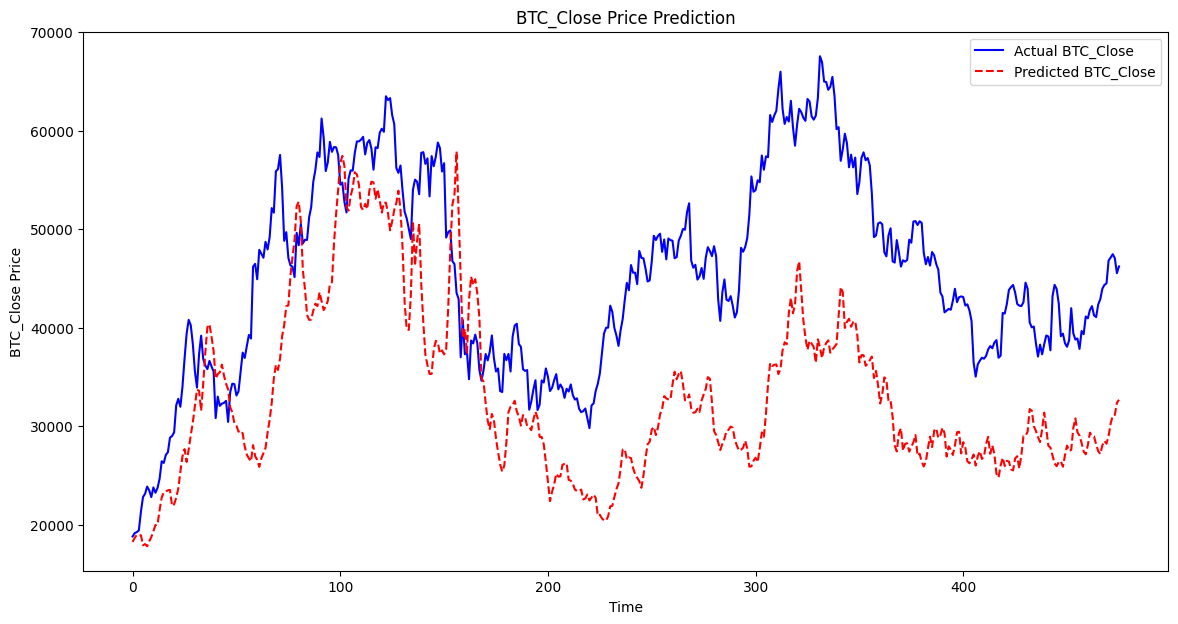

In [12]:
# Plot the predictions against the actual values
plt.figure(figsize=(14, 7))
plt.plot(Y_test, color='blue', label='Actual BTC_Close')
plt.plot(predictions, color='red', label='Predicted BTC_Close', linestyle='dashed')
plt.title('BTC_Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC_Close Price')
plt.legend()
plt.show()